In [3]:
import numpy as np
import glob, json, os, sys
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from copy import deepcopy

ts2dt = lambda x: datetime.fromtimestamp(x/1000)

In [4]:
from datetime import datetime

def overlap(s1, s2):
    # s1 overrides s2
    # returns:
    #   isOverlapFound
    #   remnant of s1 (since overriding shld be same as input)
    #   remnant of s2 (cut out s1 portions)
    
    
    if s1['start']<=s2['end'] and s1['end']>=s2['start']:
        s1Lst = s1
        s2Lst = []
        if s1['start']<=s2['start'] and s1['end']>=s2['end']:
            # s2 full inside s1
            s2Lst = []
            
        elif s1['start']<=s2['start'] and s1['end']<=s2['end']:
            # s2 cut from left-end
            s2Lst = [(s1['end'], s2['end'])]
            
        elif s1['start']>=s2['start'] and s1['end']>=s2['end']:
            # s2 cut from right-end
            s2Lst = [(s2['start'], s1['start'])]
            
        elif s1['start']>=s2['start'] and s1['end']<=s2['end']:
            # s2 split into 2 parts
            s2Lst = [(s2['start'], s1['start']), (s1['end'], s2['end'])]
            
        return True, s1Lst, s2Lst

    return False, s1, s2


In [5]:
for hrs in [[14,20], [12,14], [4,12], [4,5], [4,20]]:
    s1 = {'start':datetime(2025,1,1,6), 'end':datetime(2025,1,1,16)}
    s2 = {'start':datetime(2025,1,1,hrs[0]), 'end':datetime(2025,1,1,hrs[1])}
    print(hrs)
    print(overlap(s1,s2))
    print()


[14, 20]
(True, {'start': datetime.datetime(2025, 1, 1, 6, 0), 'end': datetime.datetime(2025, 1, 1, 16, 0)}, [(datetime.datetime(2025, 1, 1, 16, 0), datetime.datetime(2025, 1, 1, 20, 0))])

[12, 14]
(True, {'start': datetime.datetime(2025, 1, 1, 6, 0), 'end': datetime.datetime(2025, 1, 1, 16, 0)}, [])

[4, 12]
(True, {'start': datetime.datetime(2025, 1, 1, 6, 0), 'end': datetime.datetime(2025, 1, 1, 16, 0)}, [(datetime.datetime(2025, 1, 1, 4, 0), datetime.datetime(2025, 1, 1, 6, 0))])

[4, 5]
(False, {'start': datetime.datetime(2025, 1, 1, 6, 0), 'end': datetime.datetime(2025, 1, 1, 16, 0)}, {'start': datetime.datetime(2025, 1, 1, 4, 0), 'end': datetime.datetime(2025, 1, 1, 5, 0)})

[4, 20]
(True, {'start': datetime.datetime(2025, 1, 1, 6, 0), 'end': datetime.datetime(2025, 1, 1, 16, 0)}, [(datetime.datetime(2025, 1, 1, 4, 0), datetime.datetime(2025, 1, 1, 6, 0)), (datetime.datetime(2025, 1, 1, 16, 0), datetime.datetime(2025, 1, 1, 20, 0))])



### Some of the catches / scenarios handled
- later user session should override previous user sessions 
- should not double count overlapping times for user (merge similar type sessions)
- multiple camera session overlapping with user session will be dropped (e.g. 2-5 2 vehicles are present, 3-5 user says the driver is present then the count will be 3-5 (2hrs) + 2-3 (1 hrs) 1st vehicle + 2-3 (1 hrs) 2nd vehicle = 4 hrs)
- finally only camera sessions where there is no user session will be retained as is

In [6]:
attendance range: 5 Jan - 10 Jan
Cam session: 4 Jan - 6 Jan --> 5 Jan - 6 Jan

In [7]:
# reconcile sessions
from copy import deepcopy

def reconcileSessions(sessionsList):
    # sessionsList: [{'sessId':'id', 'sign':'p/n', 'type':'sys/user', 'start':time, 'end':time}, ..]
    # Approach:
    #  1. Get final user session: lastest (last) user session as the over-rides prev ones
    #  2. Edit sys(cam) session by final user session:
    #     basically collect only remnants as camera based inputs, else all is overridden by user input
    
    
    # 1. reconcile user sessions into pSess (+ve) and nSess(-ve)
    userSess = []
    for sess in sessionsList:
        if sess['type']=='sys':
            continue
        newSess = deepcopy(sess)
        
        modSess = [] # track how older sessions are modified by the latest session
        for nSess, prevSess in enumerate(userSess):
            isOverlap, s1Lst, s2Lst = overlap(sess,prevSess) # latest user session takes precendence
            if isOverlap:
                    
                if newSess['sign']==prevSess['sign']: # merge similar sess
                    newSess['start'] = min(newSess['start'], prevSess['start'])
                    newSess['end'] = max(newSess['end'], prevSess['end'])
                    modSess.append((nSess,None)) # remove prev added session, since its combined into newSess
                elif len(s2Lst)==0:
                    # nothing remains of 2nd session so remove it
                    modSess.append((nSess,None)) 
                else:
                    for ntim, tims in enumerate(s2Lst):
                        mSess = deepcopy(prevSess)
                        mSess['start'] = tims[0]
                        mSess['end'] = tims[1]
                        # if a session is split into 2 then only once the original entry shld be removed
                        rmIndex = nSess if ntim==0 else -1
                        modSess.append((rmIndex, mSess))
                        
        # add back the modified sessions
        for nSess, sess in modSess[::-1]:
            if nSess>=0:
                userSess.pop(nSess)
            if sess is not None:
                userSess.append(sess)
        # latest session (overriding one) is added as is
        userSess.append(newSess)
        
    # 2. Collect remnants of each camera session after being overridden by user session
    sysSess = []
    for sess in sessionsList:
        if sess['type']=='user':
            continue

        newSessions = [deepcopy(sess)] # holder to keep track of sessions (can break, disappear)

        # check with all (final) user sessions
        for nSess, curUserSess in enumerate(userSess):
            modSess = [] # track how the current (cam) session is modified by curUserSess
            for chkSess in newSessions:
                isOverlap, s1Lst, s2Lst = overlap(curUserSess, chkSess) # user session takes precedence                    
                if isOverlap:
                    # if there is overlap then collect the remnants
                    for tims in s2Lst:
                        mSess = deepcopy(chkSess)
                        mSess['start'] = tims[0]
                        mSess['end'] = tims[1]
                        modSess.append(mSess)
                else:
                    # if noOverlap then session is as is
                    modSess.append(chkSess)
            newSessions = deepcopy(modSess) # work with modified session for rest of userSess check

        # add the modified session to final list
        sysSess += newSessions
                
#         plt.figure()
#         plotSessions(sysSess)
#         plotSessions(userSess, offset=2)
        
    # count present hours between sysSess and userSess
    pHrs, nHrs = 0, 0
    for sess in sysSess+userSess:
        dur = (sess['end']-sess['start']).total_seconds()/3600.0
        if sess['sign']=='p':
            pHrs += dur
        else:
            nHrs += dur
    
    return (pHrs, nHrs), {'userSess':userSess, 'sysSess':sysSess}
    

In [20]:

def getTime(hrs):
    vs = hrs.split(':')
    if len(vs)==2:
        return datetime(2025,1,1,int(vs[0]), int(vs[1]))
    return datetime(2025,1,1,int(vs[0]))
    
camSess = []

for hrs in [['6','11'], ['13','16:30'], ['18','20'], ['6','22']]:
    s2 = {'start': getTime(hrs[0]), 'end':getTime(hrs[1])}
    s2['sign'] = 'p'
    s2['id'] = 'id_%d'%(len(camSess)+1)
    s2['type'] = 'sys'
    camSess.append(s2)
    
for hrs in [['10','13:30']]:
    s2 = {'start': getTime(hrs[0]), 'end':getTime(hrs[1])}
    s2['sign'] = 'p'
    s2['id'] = 'id_%d'%(len(camSess)+1)
    s2['type'] = 'sys'
    camSess.append(s2)
    
userSess = []
for hrs in [['6','11','p'], ['16','22','p'], ['12','19','p']]:#, ['4','23','p']]:
    s2 = {'start': getTime(hrs[0]), 'end':getTime(hrs[1])}
    s2['sign'] = hrs[2]
    s2['id'] = 'id_%d'%(len(camSess)+1)
    s2['type'] = 'user'
    userSess.append(s2)
    
allSess = camSess + userSess

In [21]:
hrs, meta = reconcileSessions(allSess)
print(hrs)

(17.0, 0)


Text(0.5, 1.0, 'Cam:black, User(present):green, User(absent):red')

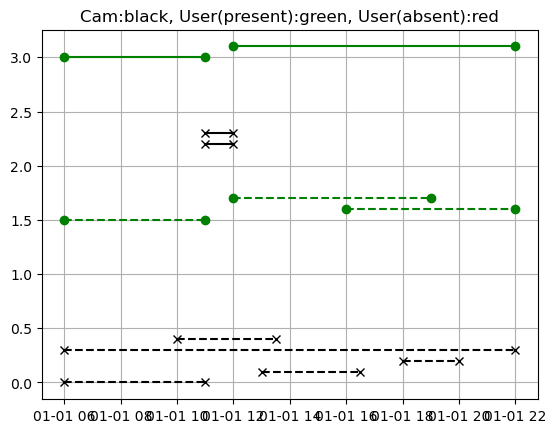

In [22]:

def plotSessions(sessions, offset=0, lstyle='-'):
    for nsess, sess in enumerate(sessions):
        col = 'kx'
        val = 0 + offset + nsess*0.1
        if sess['type']=='user':
            val = 1 + offset + nsess*0.1
            col = 'go'
            if sess['sign']=='n':
                col = 'ro'
        plt.plot([sess['start'], sess['end']], [val]*2, lstyle+col)
        
plotSessions(allSess, lstyle='--')
plotSessions(meta['userSess']+meta['sysSess'], offset=2)
plt.grid()
plt.title('Cam:black, User(present):green, User(absent):red')